#**과대적합/과소적합(Overfitting/Underfitting)**

과대적합: **훈련세트에서 좋은 성능**을 내지만, **검증세트에서 낮은 성능**을 보임   
과소적합: 훈련세트와 검증세트 모두 낮은 성능을 보임

과대적합된 모델을 '분산이 크다'라고 한다.   
과소적합된 모델은 '편향이 크다'라고 한다.

과대적합/과소적합된 모델 사이의 관계를 **'분산-평향 트레이드오프'**라고 한다.

###**Bias-Variance Tradeoff**

편향을 줄이면(성능을 높이면) 분산이 커지고(과대적합)   
분산을 줄이면(성능차를 줄이면) 편향이 커진다(성능이 낮아짐)  

따라서 분산과 편향의 중간 최적점을 선택해야 한다.

이제 에포크 횟수에 따라 모델의 손실을 그래프로 그려보고   
분산-편향의 중간 최적점을 찾아보자.


In [ ]:
# import dependencies

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
c_data = cancer.data
c_target = cancer.target
train_data_all, test_data, train_target_all, test_target = train_test_split(c_data, c_target, stratify=c_target, test_size=0.2, random_state=42)
train_data, val_data, train_target, val_target = train_test_split(train_data_all, train_target_all, stratify=train_target_all, test_size=0.2, random_state=42)
train_mean = np.mean(train_data, axis=0)
train_std = np.std(train_data, axis=0)
train_data_scaled = (train_data - train_mean) / train_std
val_data_scaled = (val_data - train_mean) / train_std

###**앞서 구현했던 SingleLayer 클래스를 다음과 같이 수정한다.**
1. \_\_init__() 메서드에 검증세트에 대한 손실을 기록할 val_losses 인스턴스 변수를 추가한다.
2. fit() 메서드에 검증세트를 전달받을 수 있도록 x_val, y_val 파라미터를 추가한다.
3. fit() 메서드에서 매 에포크마다 update_val_loss() 메서드를 호출하여 검증세트 손실을 기록한다.
4. update_val_loss() 메서드에서 모델의 현재 선형회귀 직선 성능으로 검증세트를 정방향 계산한 후, 손실을 기록한다.

In [ ]:
class SingleLayer:

  def __init__(self, learning_rate=0.1):
    self.w = None   # 입력데이터의 특성이 많아 가중치와 절편을 미리 초기화하지 않는다.
    self.b = None   # 나중에 입력데이터를 보고 특성 개수에 맞게 결정
    self.losses = []
    self.w_history = []   # 가중치를 저장할 리스트
    self.lr = learning_rate   # 학습률 
    self.val_losses = []    # 검증세트 손실을 기록할 리스트

  def forpass(self, x):
    z = np.sum(self.w * x) + self.b   # x와 w는 1차원 배열이므로 np.sum을 이용해 모든 요소를 다 더한다.
    return z


  def backprop(self, x, err):   # 오차역전파 메서드
    w_grad = x * err
    b_grad = err
    return w_grad, b_grad


  def fit(self, x, y, epochs=100, x_val=None, y_val=None):  # 검증세트를 전달받을 x_val, y_val 추가
    self.w = np.ones(x.shape[1])  # 가중치와 절편 초기화
    self.b = 0
    self.w_history.append(self.w.copy())  # 가중치 기록 -> 넘파이 배열(w)을 추가하면 실제값이 추가되는 것이 아닌 배열을 참조하기 때문에 w값이 바뀌면 그 값을 복사하여 추가해주어야 한다.
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # 샘플 개수만큼의 인덱스 섞기
      for i in indexes:
        z = self.forpass(x[i])   # 정방향 계산
        a = self.activation(z)  # 정방향 계산의 결과값인 z를 활성화 함수에 통과
        err =  -(y[i] - a)       # 활성화 함수를 거친 a값으로 오차량 계산
        w_grad, b_grad = self.backprop(x[i], err)  # 오차역전파
        self.w -= self.lr * w_grad   # 그레이디언트 업데이트  (학습률 적용)
        self.b -= b_grad
        self.w_history.append(self.w.copy())  # 가중치 기록
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i] * np.log(a) + (1 - y[i]) * np.log(1 - a))  # 로지스틱 손실함수 -(ylog(a) - (1 - y)log(1 - a))
      self.losses.append(loss/len(y))
      self.update_val_loss(x_val, y_val)  # 검증세트 손실을 업데이트하는 메서드 호출

  
  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i] * np.log(a) + (1 - y_val[i]) * np.log(1 - a))
    self.val_losses.append(val_loss / len(y_val))


  def activation(self, z):  # 활성화 함수
    z = np.clip(z, -100, None)    # 안전한 계산을 위해 클리핑
    a = 1 / (1 + np.exp(-z))
    return a


  def predict(self, x): # 예측 함수
    z = [self.forpass(x_i) for x_i in x]
    return np.array(z) > 0  # 계단함수


  def score(self, x, y):    # 평가함수
    return np.mean(self.predict(x) == y)

In [ ]:
layer3 = SingleLayer()
layer3.fit(train_data_scaled, train_target, x_val=val_data_scaled, y_val=val_target)

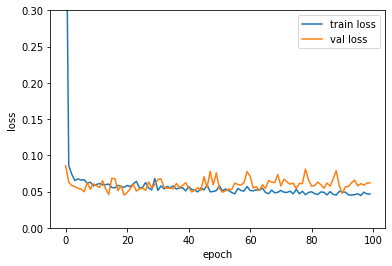

In [ ]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train loss', 'val loss'])
plt.show()

그래프를 보면 대략 20번째 에포크 이후 훈련세트보다 검증세트의 손실이 더욱 커지는 것을 알 수 있다.   
즉, 에포크가 진행될수록 검증세트보다 훈련세트에 맞게 된다는 의미이다.   

따라서 20번째 에포크 이후로는 훈련을 진행할 필요가 없다.

In [ ]:
layer4 = SingleLayer()
layer4.fit(train_data_scaled, train_target, epochs=20)
layer4.score(val_data_scaled, val_target)

0.978021978021978